<a href="https://colab.research.google.com/github/s-c-soma/AlternusVera/blob/master/PrevWork_Factor_NewsCoverage_ScoreComputing_wk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Factor : News Coverage 

by **Subarna Chowdhury Soma** [SJSU ID: 014549587]

> * Project : Alternus Vera Iteration 1
> * Team: The Mean Squares


## Colab Details



** Week 1: **

> * Colab 1: Factor_NewsCoverage_StoryClustering.ipynb
> * Colab 2: Factor_NewsCoverage_ScoreComputing.ipynb

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparation
### Imports
First some of the required packages must be imported.

## Import Library

In [0]:
import argparse
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import warnings
from string import punctuation
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import nltk
import re
import io
import requests
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk.sentiment

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## All News Dataset


The notebook uses Kaggle's "All the news" dataset to curate reference articles to enrich the study of news coverage analysis (Thompson, 2017).

The relevant dataset files are downloaded from Kaggle, unzipped and re-uploaded to GitHub repository (Thompson, 2017).

https://www.kaggle.com/snapcrack/all-the-news/home

### Parameter configuration

In [0]:
#'google','vader','stanford'
runParams={'sentiment_library':   ['vader'],
           'input_file':          ['/content/drive/My Drive/Colab Notebooks/articles1.csv'],
           'output_file':         ['/content/drive/My Drive/Colab Notebooks/fakenews_by_news-coverage.csv'],
           'article_id_list':     [[120639,80103,25225,21502,57362,120636]],
           'sentiment_sentences': [5],
           'article_stats':       [False]}

# Use parameter grid even if there is only set of parameters
parameterGrid=ParameterGrid(runParams)

## Liar Liar Dataset

In [0]:
def get_parsed_data(url, sep='\t', header=None ):
  return pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')), sep=sep, header=header )

# Download and parse the dataset... Let us first work with 100 articles
KAGGLE_DATASET = 'https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle'
data_kaggle = get_parsed_data('%s/kaggle-fake.csv'% KAGGLE_DATASET, ',' , 'infer' )[:1000]


# Distillation

## Tokenization
As part of the distillation, we tokenize the headline and the body of the articles, by the following methods. First the words are split based on the white space. We also use this step to combine the title with the body of the article.

In [0]:
data_kaggle['text_distilled'] = data_kaggle['title'].apply(lambda x : re.split('\W+', str(x).lower())) +\
   data_kaggle['text'].apply(lambda x : re.split('\W+', str(x).lower()))
data_kaggle.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, they, stole, millions, in, g..."


In [0]:
data_kaggle.text_distilled[0][:25]

['muslims',
 'busted',
 'they',
 'stole',
 'millions',
 'in',
 'gov',
 't',
 'benefits',
 'print',
 'they',
 'should',
 'pay',
 'all',
 'the',
 'back',
 'all',
 'the',
 'money',
 'plus',
 'interest',
 'the',
 'entire',
 'family',
 'and']

## Lemmatization
First, the raw words must be converted to root forms. The words are converted to their root stems based on the following using lemmaitization. Stemming using nltk.PorterStemmer was used previously, but eventually dropped due to its method of dropping suffixes without correction to the root stem. For example, stemming resulted in non-existent words such as 'plu', 'interest', 'entir', 'famili', 'everyon'.

In [0]:
def lemmatize(tokenized_words):
  text = [nltk.WordNetLemmatizer().lemmatize(word) for word in tokenized_words]
  return text

# Commented out per rationale above
#def stemming(tokenized_words):
#  text = [nltk.PorterStemmer().stem(word) for word in tokenized_words]
#  return text

data_kaggle['text_distilled_lemma'] = data_kaggle['text_distilled'].apply(lemmatize)
data_kaggle.text_distilled[0][:15]

['muslims',
 'busted',
 'they',
 'stole',
 'millions',
 'in',
 'gov',
 't',
 'benefits',
 'print',
 'they',
 'should',
 'pay',
 'all',
 'the']

## Removing Stop words
Let us remove stop words, which are absolutely critical in determining keywords indicative of timed event.

In [0]:
english_stopwords = set(stopwords.words('english') + list(punctuation) + [''])

def remove_stopwords(tokenized_words):
  text = [word for word in tokenized_words if word not in english_stopwords]
  return text

data_kaggle['text_distilled'] = data_kaggle['text_distilled'].apply(remove_stopwords)
data_kaggle.text_distilled[0][:15]

['muslims',
 'busted',
 'stole',
 'millions',
 'gov',
 'benefits',
 'print',
 'pay',
 'back',
 'money',
 'plus',
 'interest',
 'entire',
 'family',
 'everyone']

## Custom Filtering
One or two-letter words from the tokenized words are also removed to further cleanse the raw text. First, two-letter words are chosen one by one (there are roughly 100 to 150 words, plus some common country codes). Each word, is examined whether it is worth keeping. Of course, there are more two-letter words than the whitelist shown below, but many of them (e.g. so, am, it) are already eliminated using stop words. If we build a dictionary of all these non-trivial words that are two-letters long, this will help improve the accuracy of the model.

In [0]:
whitelist = set(['ai', 'ax', 'ca', 'eu', 'go', 'io', 'la', 'ox', 'us', 'uk', 
                 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 
                 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi',
                 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
                 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
                 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy' ])
def remove_too_short(tokenized_words):
  text = [word for word in tokenized_words if (len(word) >= 3 or word not in whitelist) ]
  return text

In [0]:
data_kaggle['text_distilled'] = data_kaggle['text_distilled'].apply(remove_too_short)
data_kaggle.text_distilled[0][:15]

['muslims',
 'busted',
 'stole',
 'millions',
 'gov',
 'benefits',
 'print',
 'pay',
 'back',
 'money',
 'plus',
 'interest',
 'entire',
 'family',
 'everyone']

# Topic Modeling

## LDA Analysis


We will use topic modelling (LDA) to identify the key topics, https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [0]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

def topics(tokenized_words):
    d = Dictionary([tokenized_words])
    c = [d.doc2bow(tokenized_words)]
    m = LdaModel(c, num_topics=1, id2word=d)
    return list(m.print_topics(num_words=2))
  
data_kaggle['topics'] = data_kaggle['text_distilled'].apply(topics)

## Analyzing the topics of some sample articles:

In [0]:
data_kaggle.title[1],data_kaggle.topics[1]

('Re: Why Did Attorney General Loretta Lynch Plead The Fifth?',
 [(0, '0.033*"lynch" + 0.020*"attorney"')])

In [0]:
data_kaggle.title[2],data_kaggle.topics[3]

('BREAKING: Weiner Cooperating With FBI On Hillary Email Investigation',
 [(0, '0.049*"speech" + 0.037*"donald"')])

In [0]:
data_kaggle.title[3],data_kaggle.topics[3]

('PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnapped And Killed By ISIS: "I have voted for Donald J. Trump!" » 100percentfedUp.com',
 [(0, '0.049*"speech" + 0.037*"donald"')])

In [0]:
data_kaggle.title[4],data_kaggle.topics[4]

("FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 [(0, '0.022*"insurance" + 0.016*"must"')])

In [0]:
len(data_kaggle.title)

1000

## Topics as Simple List of Words
A list of topic terms is compiled as show below. The coefficients in front of each word are dropped as part of simplification. The assumption is that the top two words comprising the topic, are both significant enough to be treated equally. It is important that the goal is to build a reliable prediction model. While there is a risk of oversimplification, if the final model results in a poor accuracy score, the coefficient can always be reintroduced here.

In [0]:
def parseTopics(topics):
   output = []
   words = topics[0][1].split( '+' )
   for word in words:
       output.append( word.split('*')[1].replace( '"', '' ) )
   return output

data_kaggle['topics'] = data_kaggle['topics'].apply(parseTopics)

In [0]:
data_kaggle.title[1],data_kaggle.topics[1]

('Re: Why Did Attorney General Loretta Lynch Plead The Fifth?',
 ['lynch ', 'attorney'])

# Distillation (All News Data)

## Data Enrichment  (All News Data)
The notebook uses Kaggle's "All the news" dataset to compute coverage score for news coverage



## Cleaning Articles

This is the same function as used in Part One.

In [0]:
def getInputDataAndDisplayStats(filename,processDate,printSummary=False):

	df=pd.read_csv(filename)

	df=df.drop_duplicates('content')
	df=df[~df['content'].isnull()]

	
	df=df[df['content'].str.len()>=200]

	# Find and remove summary NYT "briefing" articles to avoid confusing the clustering
	targetString="(Want to get this briefing by email?"
	df['NYT summary']=df['content'].map(lambda d: d[:len(targetString)]==targetString)
	df=df[df['NYT summary']==False]

	# The following removes a warning that appears in many of the Atlantic articles.
	# Since it is commonly at the beginning, it brings a lot of noise to the search for similar articles
	# And subsequently to the assessment of sentiment
	targetString="For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below"
	df['content']=df['content'].str.replace(targetString,'')

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# More Atlantic-specific removals (for daily summaries with multiple stories contained)
	df=df[df['content'].str.contains("To sign up, please enter your email address in the field")==False]

	# Remove daily CNN summary
	targetString="CNN Student News"
	df=df[df['content'].str.contains(targetString)==False]

	if printSummary:
		print("\nArticle counts by publisher:")
		print(df['publication'].value_counts())

		print("\nArticle counts by date:")
		print(df['date'].value_counts())
		

	if processDate!=None:
		df=df[df['date']==processDate]
	df.reset_index(inplace=True, drop=True)

	# Remove non-ASCII characters
	df['processed_content']=df['content'].map(lambda x: removeNonASCIICharacters(x))
	df['score'] = 0.0

	print("\nFinal dataset:\n\nDate:",processDate,"\n")
	print(df['publication'].value_counts())

	return df

##########################################################################################

def removeNonASCIICharacters(textString): 
    return "".join(i for i in textString if ord(i)<128)

## First level of cleaning


In [0]:
articleDataFrame=getInputDataAndDisplayStats(runParams['input_file'][0],None,False)


Final dataset:

Date: None 

Breitbart           23585
CNN                 11249
New York Times       7620
Business Insider     6504
Atlantic              157
Name: publication, dtype: int64


In [0]:
articleDataFrame.date.unique

<bound method Series.unique of 0        2016-12-31
1        2017-06-19
2        2017-01-06
3        2017-04-10
4        2017-01-02
            ...    
49110    2017-01-11
49111    2017-01-11
49112    2017-01-11
49113    2017-01-11
49114    2017-01-11
Name: date, Length: 49115, dtype: object>

In [0]:
articleDataFrame.shape

(49115, 13)

In [0]:
col_id_list = articleDataFrame['id'].tolist()
#col_id_list 

In [0]:
# All News Kaggle

def get_parsed_data2(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')

# download and parse the dataset...
articleDataFrame = get_parsed_data2('https://media.githubusercontent.com/media/hyunwookshin/all_news_dataset_kaggle/master/articles1.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [0]:
#articleDataFrame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/articles1.csv', low_memory =False, encoding = "ISO-8859-1")
articleDataFrame.head(20)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
5,5,17288,"Sick With a Cold, Queen Elizabeth Misses New Y...",New York Times,Sewell Chan,2017-01-02,2017.0,1.0,NaN,"LONDON — Queen Elizabeth II, who has been b..."
6,6,17289,Taiwan’s President Accuses China of Renewed In...,New York Times,Javier C. Hernández,2017-01-02,2017.0,1.0,NaN,BEIJING — President Tsai of Taiwan sharpl...
7,7,17290,"After ‘The Biggest Loser,’ Their Bodies Fought...",New York Times,Gina Kolata,2017-02-08,2017.0,2.0,NaN,"Danny Cahill stood, slightly dazed, in a blizz..."
8,8,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ..."
9,9,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...


## Distillation - Tokenization

In [0]:
articleDataFrame['text_distilled'] = articleDataFrame['title'].apply(lambda x : re.split('\W+', str(x).lower())) +\
   articleDataFrame['content'].apply(lambda x : re.split('\W+', str(x).lower()))

## Distillation - Stop Words

In [0]:
articleDataFrame['text_distilled'] = articleDataFrame['text_distilled'].apply(remove_stopwords)

## Distillation - Additional

In [0]:
articleDataFrame['text_distilled'] = articleDataFrame['text_distilled'].apply(remove_too_short)
articleDataFrame.text_distilled[0][:15]

['house',
 'republicans',
 'fret',
 'winning',
 'health',
 'care',
 'suit',
 'new',
 'york',
 'times',
 'washington',
 'congressional',
 'republicans',
 'new',
 'fear']

## Distillation - Topic Analysis - Running LDA to Extract Topics

In [0]:
articleDataFrame['topics'] = articleDataFrame['text_distilled'].apply(topics)

Making sure that the distillation is succesful, the following snippet was run.

In [0]:
articleDataFrame.title[0], articleDataFrame.topics[0]

('House Republicans Fret About Winning Their Health Care Suit - The New York Times',
 [(0, '0.024*"house" + 0.020*"republicans"')])

## Take All Columns

In [0]:
articleDataFrame['id'].count()

50000

Comment this line if not want to take all the IDs

In [0]:
runParams['article_id_list'][0] = col_id_list 

# News Coverage Analysis

## Scoring Coverage (Ranking)
The latent topics are parsed from non-fake news datset. To make an appropriate scoring coverage, the latent topics between kaggle "All News Data" set and Liar Liar dataset (data_kaggle) are compared.

In [0]:
def setDate( published ):
   return published.split( "T" )[0]

data_kaggle[ 'date' ] = data_kaggle.published.apply( setDate )

In [0]:
data_kaggle.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, stole, millions, gov, benefi...","[muslim, busted, they, stole, million, in, gov...","[benefits , government]",2016-10-26


The coverage window is simply a time-range where two articles are considered to be pushed in the same approximate "time frame". Narrowing the window size will result in low coverage score across all rows. Increasing the window size will result in high coverage score across all rows. The choice of the window size was arbitrary (30 days). Please see section 7.17 for 60-day coverage window.

In [0]:
import datetime

def window( datestring, n ):
   d = datetime.datetime.strptime( datestring, "%Y-%m-%d" )
   delta = datetime.timedelta(days=n)
   fromdate = datetime.datetime.strftime(d - delta, "%Y-%m-%d")
   todate = datetime.datetime.strftime(d + delta, "%Y-%m-%d")
   return ( fromdate, todate )

Please note that coverage scoring below can take about 10~15 minutes to complete (With GPU Hardware accelerator).

In [0]:
import datetime

print( "Start Time", datetime.datetime.now() )

def coverage( article ):
   fromdate, todate = window( article[ 'date' ], 15 )
   selected_coverage = articleDataFrame[(articleDataFrame['date'] > fromdate) & (articleDataFrame['date'] < todate)]
   selected_coverage['covered'] = selected_coverage.apply( lambda r: r[ 'topics' ][0] in article.topics and
                                                       r[ 'topics' ][1] in article.topics, axis=1 )
   return len(selected_coverage[selected_coverage['covered'] == True])

data_kaggle[ 'coverage' ] = data_kaggle.apply( coverage, axis=1 )

print( "Finished Time", datetime.datetime.now() )

Start Time 2020-04-26 09:07:20.827519


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Finished Time 2020-04-26 09:09:15.321094


In [0]:
data_kaggle.sort_values(by=['coverage'], ascending=False ).head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date,coverage
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, stole, millions, gov, benefi...","[muslim, busted, they, stole, million, in, gov...","[benefits , government]",2016-10-26,0
671,9cf9163fcb8564e3e3e51f13b7dc78a1eeb60445,0,Alex Ansary,2016-11-03T21:04:03.190+02:00,"Protesters, Police Still Clashing Over Dispute...","Protesters, Police Still Clashing Over Dispute...",english,2016-11-03T21:04:03.190+02:00,amtvmedia.com,US,NaN,"Protesters, Police Still Clashing Over Dispute...",0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[protesters, police, still, clashing, disputed...","[protester, police, still, clashing, over, dis...","[protesters , pipeline]",2016-11-03,0
658,e5c051173c7efd9a46dc2449146c544e20f931ba,0,Alex Ansary,2016-11-02T19:14:58.593+02:00,"Bundy brothers discharged from Oregon jail, he...","Bundy brothers discharged from Oregon jail, he...",english,2016-11-02T19:14:58.593+02:00,amtvmedia.com,US,NaN,"Bundy brothers discharged from Oregon jail, he...",0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[bundy, brothers, discharged, oregon, jail, he...","[bundy, brother, discharged, from, oregon, jai...","[federal , bundy]",2016-11-02,0
659,0c9d01b2bc7e6e5be2ebecd52b54468b5bf1e731,0,Alex Ansary,2016-11-02T19:24:00.901+02:00,Warning or threat? Hillary hints at second civ...,Warning or threat? Hillary hints at second civ...,english,2016-11-02T19:24:00.901+02:00,amtvmedia.com,US,NaN,Warning or threat? Hillary hints at second civ...,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[warning, threat, hillary, hints, second, civi...","[warning, or, threat, hillary, hint, at, secon...","[clinton , war]",2016-11-02,0
660,705bbad66afa88a8b0c0c8854d107be3a4369bad,0,Alex Ansary,2016-11-02T19:24:01.278+02:00,U.S. militia girds for trouble as presidential...,U.S. militia girds for trouble as presidential...,english,2016-11-02T19:24:01.278+02:00,amtvmedia.com,US,NaN,U.S. militia girds for trouble as presidential...,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[u, militia, girds, trouble, presidential, ele...","[u, s, militia, girds, for, trouble, a, presid...","[members , said]",2016-11-02,0


In [0]:
data_kaggle.sort_values(by=['coverage'], ascending=False ).head(1)['title'], data_kaggle.sort_values(by=['coverage'], ascending=False ).head(1)['coverage']

(0    Muslims BUSTED: They Stole Millions In Gov’t B...
 Name: title, dtype: object, 0    0
 Name: coverage, dtype: int64)

## Intermediary Analysis
Label Pairing - For now, top two words of the topics are chosen in the all-news dataset, as "labels." Then using the topics of each fake news datasets and number all-news articles corresponding to each fake news article can be deduced. This means that for every article, we are searching for related articles.

Hypothetical Label Pairing for Illustration Purposes

Table A (10 articles)

| Articles | Topic Words | Computed Coverage Score | Rationale | | -- | -- | -- | | 1 | "Apple", "Banana" | 0 | Matches None from B | | 2 | "Apple", "Orange" | 1 | Matches B.2 | | 3 | "Orange", "Pear" | 2 | Matches B.3 and B.1023 | | ... | ... |

Table B (10,000 articles)

Articles	Topic Words
1	"Apple", "Pear"
2	"Apple", "Orange"
3	"Orange", "Pear"
...	...
1023	"Orange", "Pear"
...	...
Building a Model This "search" part should only be done during training stage, but not during testing and validation stages. But manually searching each row in the database is expensive and unscalable. Also, if the model simply looks up in internal database and return the score, it is more or less a search solution, not a Machine Learning Classification solution.

Instead of doing this search for every article, the model should predict how much coverage it is likely to have based on the top two topic terms and the date of publication with classifiers such as Naive Bayes or Decision Trees. Clearly it will require lot of articles for training since there will be a rich set of topic terms and dates resulting in wide range of coverage scores.

Risks There is some risk involved with this approach. Sometimes LDA and topic modeliing doesn't get us far enough. Sometimes the keywords generated by LDA such as "Car", "Bus", "Train" all have the latent super-topic called "transporation". So in our distillation not only we should filter out stop words and run lemmatization, we should condense the words even further such as "transportation". This will require additional data enrichment.

## Using word2vec to Convert Topics to Vector Embeddings
We use word2vec to fit the entire text from all articles, and then use word2vec model to convert the topic words to vectors.

In [0]:
from gensim.models import Word2Vec

m = Word2Vec( data_kaggle[ 'text_distilled' ] )

In [0]:
m.similarity( 'clinton', 'hillary' )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9209413

In [0]:
def encodeFirstColumn( topics ):
   topic = topics[0].strip()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   
data_kaggle[ 'topic_0' ] = data_kaggle.topics.apply( encodeFirstColumn )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Running few sanity check, to ensure that the computation is correct,

In [0]:
'clinton' in m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """Entry point for launching an IPython kernel.


True

In [0]:
m['hillary']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.34076   , -0.20688492,  1.0625281 ,  0.7956244 ,  0.6254588 ,
       -1.4718738 ,  0.6638465 , -0.4085298 , -0.14611132, -0.29025188,
        1.0420674 , -0.05149086,  0.33711302, -0.52381223,  0.59307176,
        0.2833357 ,  1.1587983 ,  0.5906302 ,  0.44646496, -0.33545342,
        0.4028986 , -0.0802969 ,  0.3809293 ,  0.53883183, -0.20949528,
        0.45326144, -0.37720925,  0.48270765,  0.10092717,  0.55493456,
       -0.79604787,  0.47106475, -0.13677798,  1.1848029 ,  1.2807202 ,
       -0.08843065,  1.2659123 , -0.08012204, -0.58518124,  0.69252765,
        0.05551146,  0.8819863 ,  0.15653998, -0.21041565,  0.10060433,
        0.7770395 ,  0.77330095, -0.42031643,  0.00400971,  1.474245  ,
       -0.6886547 ,  0.29213583,  1.5507023 , -0.67260754, -0.29448014,
        1.0597839 ,  0.8333858 , -0.41837195,  0.43003085,  0.05117146,
        0.7476804 , -0.34058443,  0.09018333,  0.262423  ,  0.5597528 ,
        0.31005138,  0.74758077,  0.01895826, -0.05549014, -0.15

In [0]:
data_kaggle[ 'topic_0' ][:10]

0    [0.13314050436019897, 0.02276035025715828, 0.0...
1    [0.15719249844551086, 0.029060665518045425, 0....
2    [0.21705643832683563, 0.04466809704899788, 0.0...
3    [0.2601422071456909, 0.05656076967716217, 0.02...
4    [0.16159288585186005, 0.04125561937689781, -0....
5    [-0.03145146742463112, 0.03744429722428322, 0....
6    [0.13586699962615967, 0.030349062755703926, 0....
7    [0.31141406297683716, 0.07345306873321533, 0.0...
8    [-0.03145146742463112, 0.03744429722428322, 0....
9    [0.30505669116973877, 0.17706751823425293, 0.6...
Name: topic_0, dtype: object

In [0]:
def assertDim( topic_vec ):
   assert len(topic_vec) == len(m[list(m.wv.vocab)[0]]) and len(topic_vec) > 0
    
def assertType( topic_vec ):
   assert isinstance(topic_vec, list)
    
data_kaggle.topic_0.apply( assertDim )[0]
data_kaggle.topic_0.apply( assertType )[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


The second topic term is also encoded into word2vec vector.

In [0]:
import numpy as np

vector_dim = len(m[list(m.wv.vocab)[0]])

def encodeSecondColumn( topics ):

   if len( topics ) > 1 :
      topic = topics[1].strip()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   
data_kaggle[ 'topic_1' ] = data_kaggle.topics.apply( encodeSecondColumn )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarn

In [0]:
data_kaggle.topic_1.apply( assertDim )[0]
data_kaggle.topic_1.apply( assertType )[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Sentiment Analysis
Sentiment analysis has been done on the Kaggle data set, from (Martin et. al, n.d)

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def getSentiment( text ):
    return sia.polarity_scores(text)
  
data_kaggle[ 'text_distilled_joined' ] = data_kaggle[ 'text_distilled' ].apply( lambda x : ' '.join(x) ) 
data_kaggle[ 'sentiment' ] = data_kaggle.text_distilled_joined.apply( getSentiment )

print(data_kaggle['sentiment' ][:10] )

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
0    {'neg': 0.135, 'neu': 0.669, 'pos': 0.196, 'co...
1    {'neg': 0.129, 'neu': 0.815, 'pos': 0.057, 'co...
2    {'neg': 0.051, 'neu': 0.791, 'pos': 0.158, 'co...
3    {'neg': 0.3, 'neu': 0.46, 'pos': 0.24, 'compou...
4    {'neg': 0.093, 'neu': 0.722, 'pos': 0.185, 'co...
5    {'neg': 0.356, 'neu': 0.591, 'pos': 0.053, 'co...
6    {'neg': 0.135, 'neu': 0.723, 'pos': 0.142, 'co...
7    {'neg': 0.193, 'neu': 0.735, 'pos': 0.072, 'co...
8    {'neg': 0.066, 'neu': 0.842, 'pos': 0.093, 'co...
9    {'neg': 0.152, 'neu': 0.792, 'pos': 0.056, 'co...
Name: sentiment, dtype: object


## Converting Dates to Numeric Format
The date column with format YYYY-MM-dd is converted into YYYYMM (where MM is month, and YYYY) is year. Specific day of the months is dropped to avoid overfitting.

In [0]:
def setNumericDate( date ):
   y, m, d = date.split( "-" )
   return int(y + m)

data_kaggle[ 'date_int' ] = data_kaggle.date.apply( setNumericDate )

In [0]:
data_kaggle[ 'date_int' ][0]

201610

In [0]:
data_kaggle.date_int.head(5)

0    201610
1    201610
2    201610
3    201611
4    201611
Name: date_int, dtype: int64

## Using Ranfom Forrest Classifier
Using the numeric (integer) dates, and two vectors (for top two topics chosen), a random forrest classifier is trained.

In [0]:
# First split the vectors of word2vec into individual columns

X_prep = data_kaggle[[ 'date_int', 'topic_0', 'topic_1' ]]

def select(topic_vec, idx):
   return topic_vec[idx]

prep_dict = { "date_int" : [] }
for i in range( vector_dim*2 ):
   prep_dict[str(i)] = []
    
X_COV = pd.DataFrame(prep_dict)
X_COV[ 'date_int' ] = X_prep[ 'date_int' ]

vector_dim = len(m[list(m.wv.vocab)[0]])

for i in range( vector_dim ):
   X_COV[str(i)] = X_prep.topic_0.apply( lambda x : select(x, i ) )
    
X_COV.head(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,0.133141,0.02276,0.000505,0.193098,0.090606,-0.166031,0.17109,-0.190256,-0.204141,-0.08987,0.151585,-0.046679,0.286854,0.039916,0.124656,0.118104,0.139604,0.068348,0.120777,0.022915,0.315592,-0.082241,0.054401,0.24739,0.041435,0.138863,-0.048728,0.039117,0.00639,0.097284,0.015881,0.10588,0.196704,0.202438,-0.014729,0.10339,0.144082,-0.134328,-0.299595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
for i in range( vector_dim ):
   X_COV[str(vector_dim + i)] = X_prep.topic_1.apply( lambda x : select(x, i ) )

In [0]:
X_COV.head(1)

,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,0.133141,0.02276,0.000505,0.193098,0.090606,-0.166031,0.17109,-0.190256,-0.204141,-0.08987,0.151585,-0.046679,0.286854,0.039916,0.124656,0.118104,0.139604,0.068348,0.120777,0.022915,0.315592,-0.082241,0.054401,0.24739,0.041435,0.138863,-0.048728,0.039117,0.00639,0.097284,0.015881,0.10588,0.196704,0.202438,-0.014729,0.10339,0.144082,-0.134328,-0.299595,...,-0.124945,-0.568857,-0.381606,-0.189887,0.388709,-0.137405,0.257496,0.098614,-0.108115,0.24898,0.999104,-0.168165,0.192731,0.629187,0.135066,0.223646,0.150666,-0.335486,0.534092,-0.624571,0.031893,-0.972887,-0.386115,0.097354,0.151091,-0.100819,0.184339,-0.505238,0.493485,-0.040051,0.069003,0.101926,0.324011,-0.728298,0.046542,-0.150548,-0.344977,-0.015514,0.151645,-0.141411


The following code creates training and test data.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Y_COV = data_kaggle[ 'coverage' ]
X_train, X_test, y_train, y_test = train_test_split(X_COV, Y_COV, test_size=0.33, random_state=42)
print("train:" , X_train.shape)
print("test:" , X_test.shape)

train: (670, 201)
test: (330, 201)


In [0]:
X_COV.head(3)

,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,0.133141,0.022760,0.000505,0.193098,0.090606,-0.166031,0.171090,-0.190256,-0.204141,-0.089870,0.151585,-0.046679,0.286854,0.039916,0.124656,0.118104,0.139604,0.068348,0.120777,0.022915,0.315592,-0.082241,0.054401,0.247390,0.041435,0.138863,-0.048728,0.039117,0.006390,0.097284,0.015881,0.105880,0.196704,0.202438,-0.014729,0.103390,0.144082,-0.134328,-0.299595,...,-0.124945,-0.568857,-0.381606,-0.189887,0.388709,-0.137405,0.257496,0.098614,-0.108115,0.248980,0.999104,-0.168165,0.192731,0.629187,0.135066,0.223646,0.150666,-0.335486,0.534092,-0.624571,0.031893,-0.972887,-0.386115,0.097354,0.151091,-0.100819,0.184339,-0.505238,0.493485,-0.040051,0.069003,0.101926,0.324011,-0.728298,0.046542,-0.150548,-0.344977,-0.015514,0.151645,-0.141411
1,201610,0.157192,0.029061,0.013314,0.252122,0.126144,-0.232334,0.221243,-0.223681,-0.234135,-0.115174,0.205194,-0.055308,0.348109,0.056858,0.165996,0.146724,0.175960,0.095519,0.153203,0.017035,0.394713,-0.096500,0.059357,0.300754,0.038923,0.171346,-0.054553,0.047513,0.014488,0.127616,0.012770,0.130882,0.229752,0.251314,0.009855,0.126285,0.186209,-0.161298,-0.360938,...,0.001336,-0.447362,-0.270268,-0.161780,0.373512,-0.008976,0.299983,0.063679,-0.103723,0.145099,0.743461,-0.153102,0.156540,0.407802,0.019480,0.153765,0.202535,-0.188576,0.435051,-0.434912,0.051607,-0.703885,-0.342090,0.031409,0.176686,-0.035643,0.178913,-0.388436,0.355624,-0.103681,0.080223,0.114311,0.269578,-0.524341,0.002468,-0.024183,-0.222825,0.053790,0.065441,-0.237334
2,201610,0.217056,0.044668,0.058785,0.382050,0.202786,-0.383304,0.350736,-0.330440,-0.323174,-0.154769,0.320239,-0.073156,0.471759,0.046400,0.273190,0.201521,0.288995,0.156015,0.239782,-0.007736,0.549383,-0.143233,0.100450,0.422479,0.048470,0.281399,-0.089117,0.100103,0.032319,0.206834,0.003150,0.199114,0.324852,0.404298,0.072829,0.180402,0.312731,-0.228016,-0.537070,...,0.014956,-0.312478,-0.185301,-0.122320,0.275844,0.004335,0.219421,0.053112,-0.076069,0.106048,0.526128,-0.109282,0.108851,0.274530,0.006063,0.111773,0.143344,-0.129076,0.300258,-0.293823,0.033190,-0.483857,-0.247282,0.024394,0.123597,-0.024521,0.129386,-0.266605,0.246007,-0.066114,0.066371,0.069068,0.186766,-0.359455,0.003262,-0.004505,-0.145845,0.038401,0.036339,-0.176359


In [0]:
f_cov = RandomForestClassifier(n_estimators=10)
f_cov.fit(X_train, y_train)
y_pred = f_cov.predict(X_test)

Predicting the accuracy of the coverage,

In [0]:
'Accuracy', accuracy_score(y_test, y_pred)

('Accuracy', 1.0)

The accuracy based on the unseen test data is 90%~95%. This means that using the word2vec-based model one can build a reliable coverage score.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
No handles with labels found to put in legend.


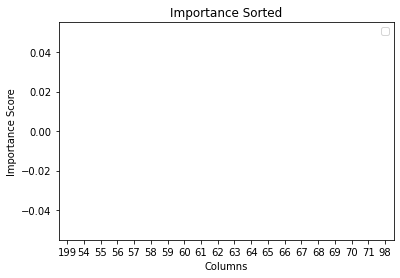

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

importantCols = pd.Series(f_cov.feature_importances_,index=list(X_COV)).sort_values(ascending=False)
sns.barplot(y=importantCols[:20], x=importantCols.index[:20])

plt.ylabel('Importance Score')
plt.xlabel('Columns')
plt.title("Importance Sorted")
plt.legend()
plt.show()

## Interpretation
As shown above "date_int" is one of the most important feature in determining whether or not the news has high news coverage. This is expected since the date the news has been posted definitely impacts on whether the news has sufficient coverage from peer articles. Some of the numeric (word2vec) columns have significant impact on the prediction of the coverage score. But, since these factors are latent, they do not correspond to specific words in the vocabulary.

## Other Methods Tried
Also tried using TFIDF as well as shown below.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

ktdv = TfidfVectorizer()
  
data_kaggle['text_distilled_joined'] = data_kaggle[ 'text_distilled' ].apply( lambda x :  ' '.join( x ) )
ktdv.fit( data_kaggle[ 'text_distilled_joined' ])
dim_row = len(ktdv.transform([data_kaggle[ 'text_distilled_joined' ][0]]).toarray())
dim_col = len(ktdv.transform([data_kaggle[ 'text_distilled_joined' ][0]]).toarray()[0])
# Eventually dropped

## Extension - Increase the window to 2 Months
Now that we have coverage of 5 and above for 6/100 articles. We can try and see what values we see if the coverage is increased from 30 days to 60 days

In [0]:
def coverage60( article ):
   fromdate, todate = window( article[ 'date' ], 60 )
   selected_coverage = articleDataFrame[(articleDataFrame['date'] > fromdate) & (articleDataFrame['date'] < todate)]
   selected_coverage['covered'] = selected_coverage.apply( lambda r: r[ 'topics' ][0] in article.topics and
                                                       r[ 'topics' ][1] in article.topics, axis=1 )
   return len(selected_coverage[selected_coverage['covered'] == True])

data_kaggle[ 'coverage60' ] = data_kaggle.apply( coverage60, axis=1 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
data_kaggle.sort_values(by=['coverage'], ascending=False ).head(10)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date,coverage,topic_0,topic_1,text_distilled_joined,sentiment,date_int,coverage60
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, stole, millions, gov, benefi...","[muslim, busted, they, stole, million, in, gov...","[benefits , government]",2016-10-26,0,"[0.13314050436019897, 0.02276035025715828, 0.0...","[0.3340817987918854, 0.04272259771823883, -0.1...",muslims busted stole millions gov benefits pri...,"{'neg': 0.135, 'neu': 0.669, 'pos': 0.196, 'co...",201610,0
671,9cf9163fcb8564e3e3e51f13b7dc78a1eeb60445,0,Alex Ansary,2016-11-03T21:04:03.190+02:00,"Protesters, Police Still Clashing Over Dispute...","Protesters, Police Still Clashing Over Dispute...",english,2016-11-03T21:04:03.190+02:00,amtvmedia.com,US,NaN,"Protesters, Police Still Clashing Over Dispute...",0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[protesters, police, still, clashing, disputed...","[protester, police, still, clashing, over, dis...","[protesters , pipeline]",2016-11-03,0,"[0.32322007417678833, 0.07965002954006195, 0.0...","[0.32374510169029236, 0.06949824839830399, -0....",protesters police still clashing disputed nort...,"{'neg': 0.191, 'neu': 0.757, 'pos': 0.052, 'co...",201611,0
658,e5c051173c7efd9a46dc2449146c544e20f931ba,0,Alex Ansary,2016-11-02T19:14:58.593+02:00,"Bundy brothers discharged from Oregon jail, he...","Bundy brothers discharged from Oregon jail, he...",english,2016-11-02T19:14:58.593+02:00,amtvmedia.com,US,NaN,"Bundy brothers discharged from Oregon jail, he...",0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[bundy, brothers, discharged, oregon, jail, he...","[bundy, brother, discharged, from, oregon, jai...","[federal , bundy]",2016-11-02,0,"[0.3503999710083008, 0.050964225083589554, -0....","[0.26084157824516296, 0.057947348803281784, -0...",bundy brothers discharged oregon jail headed n...,"{'neg': 0.244, 'neu': 0.676, 'pos': 0.08, 'com...",201611,0
659,0c9d01b2bc7e6e5be2ebecd52b54468b5bf1e731,0,Alex Ansary,2016-11-02T19:24:00.901+02:00,Warning or threat? Hillary hints at second civ...,Warning or threat? Hillary hints at second civ...,english,2016-11-02T19:24:00.901+02:00,amtvmedia.com,US,NaN,Warning or threat? Hillary hints at second civ...,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[warning, threat, hillary, hints, second, civi...","[warning, or, threat, hillary, hint, at, secon...","[clinton , war]",2016-11-02,0,"[-0.03145146742463112, 0.03744429722428322, 0....","[0.34359848499298096, 0.01666543260216713, -0....",warning threat hillary hints second civil war ...,"{'neg': 0.305, 'neu': 0.581, 'pos': 0.115, 'co...",201611,0
660,705bbad66afa88a8b0c0c8854d107be3a4369bad,0,Alex Ansary,2016-11-02T19:24:01.278+02:00,U.S. militia girds for trouble as presidential...,U.S. militia girds for trouble as presidential...,english,2016-11-02T19:24:01.278+02:00,amtvmedia.com,US,NaN,U.S. militia girds for trouble as presidential...,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[u, militia, girds, trouble, presidential, ele...","[u, s, militia, girds, for, trouble, a, presid...","[members , said]",2016-11-02,0,"[0.32212209701538086, 0.06858672201633453, 0.0...","[0.300503134727478, 0.05062494054436684, 0.053...",u militia girds trouble presidential election ...,"{'neg': 0.203, 'neu': 0.673, 'pos': 0.124, 'co...",201611,0
661,da8dad964c1fdbc0126a37b5fbb697191053fd56,0,Alex Ansary,201

Counting number of articles with coverage scores above 1

In [0]:
len(data_kaggle[data_kaggle['coverage60']>1])

0

## Testing on Non-Fake News
The coverage scores (with window = 60 days) are compared between fake news dataset and "All news" non-fake news dataset. Since window of 60 days are chosen for fake news dataset, the same window is chosen for non-fake datasets for consistency.

In [0]:
non_fake_data = articleDataFrame[:100]

non_fake_data[ 'coverage60' ] = non_fake_data.apply( coverage60, axis=1 )

IndexError: ignored

In [0]:
non_fake_data.sort_values(by=['coverage60'], ascending=False ).head(40)

Counting the number of articles with coverage score greater than 1,

In [0]:
len(non_fake_data[non_fake_data['coverage60']>1])

## Comparisons between Fake and Non-Fake News Datasets
Based on sample of 100 articles from pool of fake and non-fake news sources, the coverage score for non-fake news articles are significantly higher than the fake news articles. In particular, around 30 out of 100 of non-fake news articles had coverage score greater than one. On the other hand, only 14 out of 100 of fake news articles had coverge score greater than one.

In [0]:
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()

# News Coverage computation methods


In [0]:
class SentimentAnalyser():

	scaleMin=-1.
	scaleMax=1.

    # Initializer / Instance attributes
	def __init__(self, library):
		if library=='vader':
			self.analyser=NLTKVaderSentimentAnalyser()
		else:
			print("ERROR - NO RECOGNISED LIBRARY")

	def getOverallArticleScore(self,articleResults):

		
		numSentences=0.
		totalSentScore=0.
		for sentence in articleResults:
			numSentences+=1
			totalSentScore+=self.analyser.getSentenceScoreFromResults(sentence)

		value=(totalSentScore/numSentences-self.analyser.scaleMin)/(self.analyser.scaleMax-self.analyser.scaleMin)
		return self.scaleMin+value*(self.scaleMax-self.scaleMin)

	def generateResults(self,textToAnalyse):
		return self.analyser.generateResults(textToAnalyse)

### Vader library class


In [0]:
class NLTKVaderSentimentAnalyser():
 

	scaleMin=-1.
	scaleMax=1.

	def __init__(self):
		self.nltkVaderAnalyser=SentimentIntensityAnalyzer()
		return

	def generateResults(self,textToAnalyse):
		ss=[]
		for sentence in nl.sent_tokenize(textToAnalyse):
			ss.append(self.nltkVaderAnalyser.polarity_scores(sentence))
		return ss

	def getSentenceScoreFromResults(self,sentenceResults):
		return sentenceResults['compound']

### Computing Balance Score

In [0]:
def computePopulationBalanceScore(articleScoreDict,sentimentClass):
	population=[-1.+(x-sentimentClass.scaleMin)/(sentimentClass.scaleMax-sentimentClass.scaleMin)*(1.-(-1.)) for x in articleScoreDict.values()]
	return statistics.pstdev(population)



### Overall- Avg Score Computation for Story

In [0]:
def computePopulationBalanceScoreHistoMean(articleScoreDict,sentimentClass):

	numBuckets=len(articleScoreDict)
	articleValues=pd.Series(articleScoreDict)
	

	articleValues=articleValues/0.86

	populatedBuckets=0
	for i in range(numBuckets):
		bucketFrom=sentimentClass.scaleMin+i*(sentimentClass.scaleMax-sentimentClass.scaleMin)/numBuckets
		bucketTo=bucketFrom+(sentimentClass.scaleMax-sentimentClass.scaleMin)/numBuckets

		if bucketTo==sentimentClass.scaleMax:
			bucketTo+=0.001
		numSamples=((bucketFrom<=articleValues) & (articleValues<bucketTo)).sum()
		if numSamples>0:
			populatedBuckets+=1


	return (populatedBuckets/numBuckets * (1.-abs(articleValues.mean())))

### NC-Score: News Source Credibility 

In [0]:
def cleaning(raw_news):
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [0]:
'''
def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
'''

In [0]:
def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

In [0]:
def word_spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    correct_number  = 0
    incorrect_number = 0
    print(text)
    for i in range(len(all_words)):
        if correction(all_words[i]) == all_words[i]:
            correct_number = correct_number + 1
        else:
            incorrect_number = incorrect_number + 1
    return correct_number , incorrect_number

In [0]:
def credibility(row):
  correct, incorrect = word_spell_checker(row['processed_title'])
  if ((correct + incorrect) == 0):
    value = correct
    print('correct',correct)
    print('incorrect',incorrect)
  else: 
    value = correct/(correct + incorrect)
  return value

In [0]:
def computeCredibilityScore(articleDataFrame): 
    t1 = time.time()
    articleDataFrame['processed_title'] = articleDataFrame["title"].apply(cleaning) 
    t2 = time.time()
    print("\nProcessed title: \n", len(articleDataFrame), "news:", (t2-t1)/60, "min")

    vector = CountVectorizer()
    vector.fit(articleDataFrame['processed_content'])
    countVect = vector.transform(articleDataFrame['processed_content'])
    print(vector)

    countVect.toarray()

    articleDataFrame['credibility_score'] = articleDataFrame.apply (lambda row: credibility(row), axis=1)

 Commenting this computation for now, colab is crashing due to data load. So using other factors

In [0]:
#computeCredibilityScore(articleDataFrame)

## Story map loading


In [0]:
def setupStoryMapAndReportList(args=None,reportArticleList=None,storyMapFileName=None):

	if args==None:
		articleList=reportArticleList
		fileName=storyMapFileName
	else:
		articleList=args['article_id_list']
		fileName=args['story_map_validation']

	reportArticleList=articleList
	if fileName!=None:
		storyMap=readStoryMapFromFile(fileName)
		if reportArticleList==None:
			reportArticleList=[]
			for story, articleList in storyMap.items():
				reportArticleList.append(articleList[0])
	else:
		storyMap=None
	return storyMap,reportArticleList

def readStoryMapFromFile(filename):
	return readDictFromCsvFile(filename,'StoryMap')

##########################################################################################

def readGridParameterRangeFromFile(filename):
	return readDictFromCsvFile(filename,'GridParameters')

##########################################################################################

def readDictFromCsvFile(filename,schema):
	gridParamDict={}
	with open(filename, 'r') as f:
		for row in f:
			row=row[:-1] # Exclude the carriage return
			row=row.split(",")
			key=row[0]
			vals=row[1:]
			
			if schema=='GridParameters':
				if key in ['story_threshold','tfidf_maxdf']:
					finalVals=list(float(n) for n in vals)
				elif key in ['ngram_max','tfidf_mindf','max_length']:
					finalVals=list(int(n) for n in vals)
				elif key in ['lemma_conversion','tfidf_binary']:
					finalVals=list(str2bool(n) for n in vals)
				elif key in ['parts_of_speech']:
					listlist=[]
					for v in vals:
						listlist.append(v.split("+"))
					finalVals=listlist
				elif key in ['tfidf_norm','nlp_library']:
					finalVals=vals
				else:
					print(key)
					print("KEY ERROR")
					return
			elif schema=='StoryMap':
				finalVals=list(int(n) for n in vals)
			else:
				print(schema)
				print("SCHEMA ERROR")
				return
			
			gridParamDict[key]=finalVals
	return gridParamDict

### Load the story map from file

In [0]:
storyMap,reportArticleList=setupStoryMapAndReportList(storyMapFileName='/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/all-news-kaggle/storyMapForValidation1.csv')

In [0]:
storyMap,reportArticleList=setupStoryMapAndReportList(None,None,None)

In [0]:
if storyMap is None:
  print('')
else:
  for story, articleList in storyMap.items():
    print(story,":",articleList)

### Story map with user requested specific article list


In [0]:
def collapseRequestedArticleListIntoStoryList(requestedArticleList,storyMap):

	if storyMap==None:
		newStoryMap={}
	else:
		newStoryMap=storyMap.copy()

	found=False
	for story,articleListFromMap in newStoryMap.items():
		if len(articleListFromMap)==len(requestedArticleList):
			y=sum([x in articleListFromMap for x in requestedArticleList])
			if y==len(articleListFromMap):
				found=True
                

	if not found:
		newStoryMap[requestedArticleList[0]]=requestedArticleList
	print('newStoryMap',newStoryMap)
	return newStoryMap

## Main Process Run


In [0]:
for i,currentParams in enumerate(parameterGrid):
  if len(parameterGrid)>1:
    print("Combination:",i+1,"of",len(parameterGrid))
    print(currentParams)

  iterationStoryMap=collapseRequestedArticleListIntoStoryList(currentParams['article_id_list'],storyMap)
  sentimentAnalyser=SentimentAnalyser(currentParams['sentiment_library'])

  for story,articleList in iterationStoryMap.items():
    articleSentScores={}
    print("ANALYSING STORY:",story,"using",currentParams['sentiment_library'])
    print("Number of articles in story:",len(articleList))

    for article in articleList:
      articleContent=articleDataFrame[articleDataFrame['id']==article].iloc[0]['content']
      if currentParams['sentiment_sentences']!=None:
	      articleSentences=nl.sent_tokenize(articleContent)
	      textToAnalyse=' '.join(articleSentences[:currentParams['sentiment_sentences']])	
      else:
	      textToAnalyse=articleContent

      results=sentimentAnalyser.generateResults(textToAnalyse)
      articleSentScores[article]=sentimentAnalyser.getOverallArticleScore(results)
    
    # Sort and display results
    sortedArticleSentScores=sorted(articleSentScores.items(), key=operator.itemgetter(1))
    print("\nArticle sentiments, most positive first:")
    for article in reversed(sortedArticleSentScores):
	      print(article[0],":", round(article[1],3),articleDataFrame[articleDataFrame['id']==article[0]].iloc[0]['publication'])
	      articleDataFrame.at[articleDataFrame[articleDataFrame['id']==article[0]].index[0],'score'] = round(article[1],3)
    

    print("\nNEWS COVERAGE SCORE:",round(computePopulationBalanceScoreHistoMean(articleSentScores,SentimentAnalyser),3),"\n")


## Output inspection


In [0]:
articleDataFrame[articleDataFrame['id']==80103]#['content'].values[0]

## Fakeness Label from News Coverage Score

* positive sentiment: ``compound`` score >= 0.05 
* neutral sentiment: (``compound`` score > -0.05) and (``compound`` score < 0.05) 
* negative sentiment: ``compound`` score <= -0.05 

### Using Sentiment

###param try1

In [0]:
articleDataFrame.loc[articleDataFrame.score >= 0.05, 'label_NewsCoverage'] = 1 # true news
articleDataFrame.loc[((articleDataFrame.score > -0.05) & (articleDataFrame.score < 0.05 )), 'label_NewsCoverage'] = 2 # avg
articleDataFrame.loc[articleDataFrame.score <= -0.05, 'label_NewsCoverage'] = 0 # fake news


###param try2

In [0]:
articleDataFrame.loc[articleDataFrame.score >= 0.00, 'label_NewsCoverage'] = 1 # true news
#articleDataFrame.loc[((articleDataFrame.score > -0.05) & (articleDataFrame.score < 0.05 )), 'label_NewsCoverage'] = 2 # avg
articleDataFrame.loc[articleDataFrame.score < 0.00, 'label_NewsCoverage'] = 0 # fake news

In [0]:
print("Size of the Labels column")
print(articleDataFrame.groupby('label_NewsCoverage').size())
articleDataFrame['label_NewsCoverage'].value_counts().plot(kind="bar")
plt.ylabel('label_NewsCoverage')
plt.show()

In [0]:
articleDataFrame[articleDataFrame.id.isin([120639, 80103, 25225, 21502, 57362, 120636])]

### Using Credibility

In [0]:
def computeLabelCredibility(articleDataFrame):
    articleDataFrame.loc[articleDataFrame.credibility_score >= 0.80, 'label_credibility'] = 1 # true news
    articleDataFrame.loc[articleDataFrame.credibility_score < 0.80, 'label_credibility'] = 0 # fake news

    print("Size of the label_credibility column")
    print(articleDataFrame.groupby('label_credibility').size())
    articleDataFrame['label_credibility'].value_counts().plot(kind="bar")
    plt.ylabel('label_credibility')
    plt.show()

Commenting this computation for now, colab is crashing due to data load. So using other factors

In [0]:
#computeLabelCredibility(articleDataFrame)

## Classification

### Prepare Test and Training Data 

In [0]:

def get_words( headlines ):               
    headlines_onlyletters = re.sub("[^a-zA-Z]", " ",headlines) #Remove everything other than letters     
    words = headlines_onlyletters.lower().split() #Convert to lower case, split into individual words    
    stops = set(stopwords.words("english"))  #Convert the stopwords to a set for improvised performance                 
    meaningful_words = [w for w in words if not w in stops]   #Removing stopwords
    return( " ".join( meaningful_words )) #Joining the words

In [0]:
articleDataFrame['label_NewsCoverage'] = articleDataFrame['label_NewsCoverage'].astype('int')

In [0]:
def prepareTestTraining(x_col, y_col, articleDataFrame):
  #articleDataFrame['label_NewsCoverage'] = articleDataFrame['x_col'].astype('int')

  # Separate the dataframe for input(X) and output variables(y)
  #['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year','month', 'url', 'content', 'NYT summary', 'processed_content','score', 'label_NewsCoverage']
  X = articleDataFrame[x_col]
  Y = articleDataFrame[y_col]

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
  X_train = np.array(X_train);
  X_test = np.array(X_test);
  Y_train = np.array(Y_train);
  Y_test = np.array(Y_test);
  cleanHeadlines_train = [] #To append processed headlines
  cleanHeadlines_test = [] #To append processed headlines
  number_reviews_train = len(X_train) #Calculating the number of reviews
  number_reviews_test = len(X_test) #Calculating the number of reviews

  for i in range(0,number_reviews_train):
    cleanHeadline = get_words(X_train[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_train.append( cleanHeadline )
  for i in range(0,number_reviews_test):
    cleanHeadline = get_words(X_test[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_test.append( cleanHeadline )

  #vectorize = CountVectorizer(stop_words='english')
  vectorize = CountVectorizer(analyzer = "word",max_features = 1700)    #(stop_words='english')
  bagOfWords_train = vectorize.fit_transform(cleanHeadlines_train)
  X_train = bagOfWords_train.toarray()
  bagOfWords_test = vectorize.transform(cleanHeadlines_test)
  X_test = bagOfWords_test.toarray()

  #call autoML
  callAutoML(X_train,Y_train,X_test,Y_test)

### Auto ML

In [0]:
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
#models.append(('KNN' , KNeighborsClassifier()))
#models.append(('CART' , DecisionTreeClassifier()))
#models.append(('NB' , GaussianNB()))
#models.append(('SVM' , SVC()))
models.append(('MNB', MultinomialNB()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
#models.append(('XGBoost', XGBClassifier()))

In [0]:
def callAutoML(X_train,Y_train,X_test,Y_test):
  results = []
  names = []

  '''
  for name, model in models:
      kfold = KFold(n_splits=num_folds, random_state=42)
      cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg) '''

  for name, model in models:
      clf = model
      clf.fit(X_train, Y_train)
      Y_pred = clf.predict(X_test)
      accu_score = accuracy_score(Y_test, Y_pred)
      print(name + ": " + str(accu_score))

In [0]:
prepareTestTraining('processed_content','label_NewsCoverage',articleDataFrame)

## Save to CSV

In [0]:
#articleDataFrame.to_csv (runParams['output_file'][0], index = False, header=True)

# Description and Insight



## News Coverage

* This factor investigates news coverage of the same story in different media outlets. Later this factor classified model will be used to measure fakeness in data. 

## Data Narrative

* In this colab I have implement the different computation methods using different metrics and techniques to compute news coverage. This data has news from different popular media outlets from years of 2016 and July 2017
* This dataset has 50k rows and 13 columns including news with published and publishing timestamp. To clarify some terms:
>> * ARTICLE - a single article printed by one news publication
>> * STORY - the underlying event that an article is in reference to
 


## Pre-processing

* Preprocessing and data clean up is done using NLTK to perform following NLP preprocessing on data. 
 
>> * Removing stopwords
>> * Remove special character
>> * Remove punctuations
>> * Lowercase 
>> * Stemming 
>> * Lemmatization
>> * Removing junk and "briefing" articles
>> * Removing Daily Summary articles
>> * Removing non-ASCII characters
>> * Parts-of-speech filtering 

## Implementation Details
 
* In the first colab First story clusters have been determined. The individual articles within each story are analyzed to measure neutrality. For this, I have used Vadar library to get a sentiment score. Sentiment is aggregated to compute the coverage of the story also.  
 
* Next metric is measuring the 'balance' of coverage. It is done by identifying the top point of views( key words). Each point on the sentiment scale represents a distinct point of view. 
 
* These two terms are then averaged to measure how well balanced
the overall coverage of the story is. A perfect score for the aggregate coverage of a story is 1.
 
* As this data set is unlabelled, so I have to label this data to implement classification model. I have a threshold to identify 'good/bad' [1/0] coverage based on news coverage score. This value is stored in 'label_NewsCoverage' column. I have fine tuned the threshold multiple times. 
 
* Finally I have used autoML to try different classification algorithms to compare accuracy. The Logistic Regression Model has performed well with 75% accuracy. Here are the rest of the results: 

Factor | Algorithm | Accuracy
--- | --- | -----
News Coverage | Logistic Regression  | 75%
News Coverage | Linear Discriminant Analysis​(LDA) | 72%
News Coverage | Multinomial Bayes | 70%
News Coverage | Random Forest  | 72%

 
* **Future Work and Challenges** : 
 To compare and compute news coverage I have thought of some other terms also,eg. biasness, readability, Dale-Chall Readability Test, credibility. In fact I have implemented credibility also in this colab. But I could not include this score because the colab is crashing for 50K data with all these computations.  So as a part of an upcoming task, I would like to implement some of these features to measure news coverage from different perspectives with better classification accuracy. 
 



# Reference

1. https://towardsdatascience.com/machine-learning-versus-the-news-3b5b479d8e6a
2. https://www.kaggle.com/arjunchandrasekhara/news-classification
3. https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183
4. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
5. https://github.com/javedsha/text-classification
6. https://github.com/sharma-vidhi/Fake-News-Detection
7. https://www.kaggle.com/thebrownviking20/k-means-clustering-of-1-million-headlines